NOTE: If the colab crashes/gives memory error with CPU, try running it locally, or updating the code to utilize GPU

Reference:

* https://github.com/allenai/FineGrainedRLHF/blob/main/fgrlhf/ppo.py#L318

* https://huggingface.co/blog/deep-rl-a2c
* https://huggingface.co/blog/deep-rl-ppo


#PPO algorithm






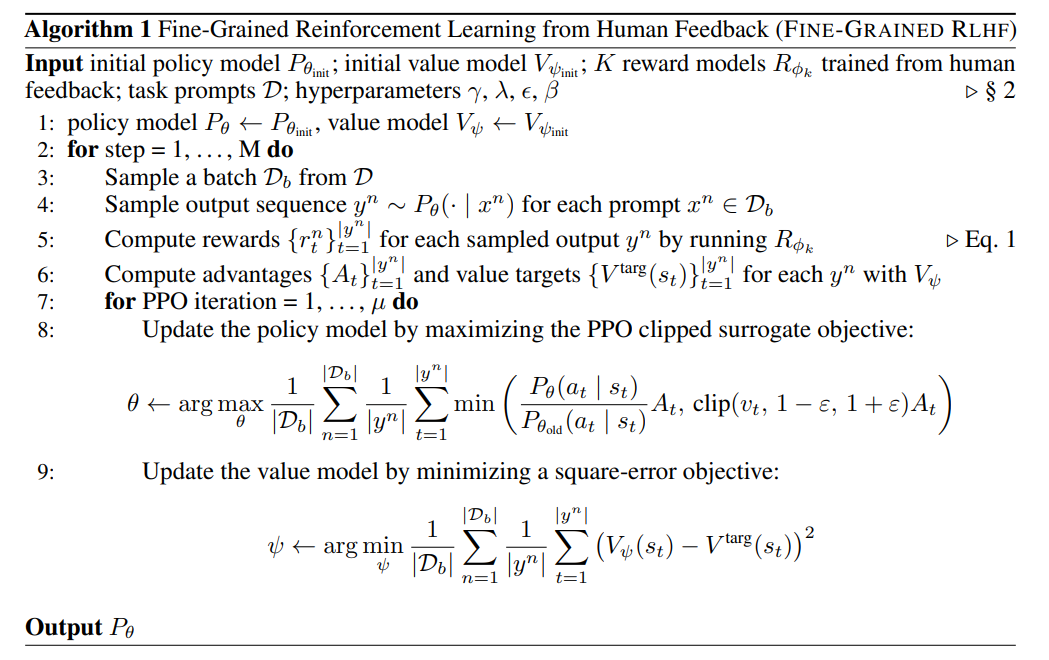

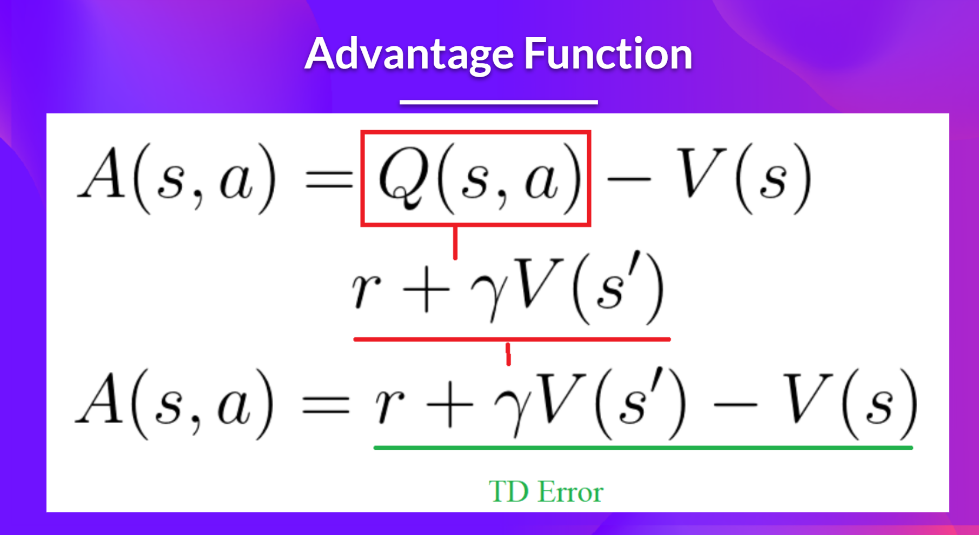

```
lastgaelam = 0
advantages_reversed = []
gen_length = mask.sum(dim=1).max().item()

for t in reversed(range(gen_length)):
  nextvalues = old_values[:, t+1] if t< gen_length -1 else 0.0
  
  delta = rewards[:, t] + self.gamma * nextvalues - old_values[:, t]

  lastgaelam = delta + self.gamma * self.ppo_lam * lastgaelam

  advantages_reversed.append(lastgaelam)


advantages = torch.stack(advantages_reversed[::-1], dim=1)
```

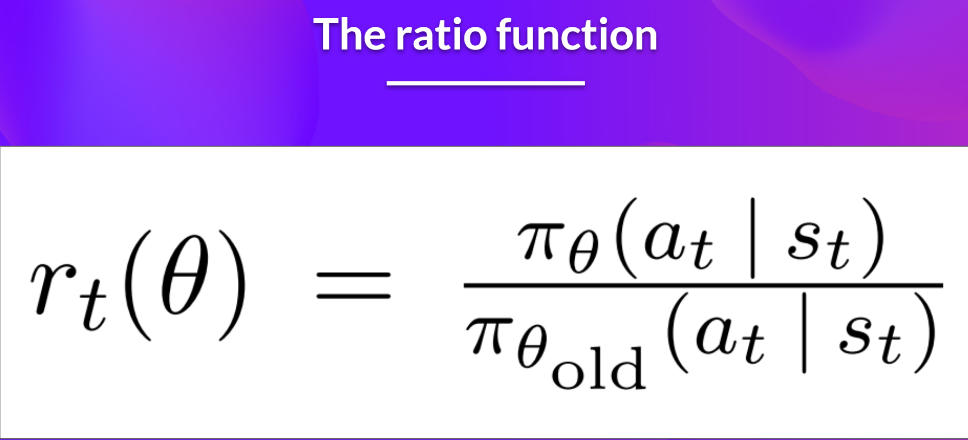



```
ratio = torch.exp(new_logprobs- old_logprobs)
```



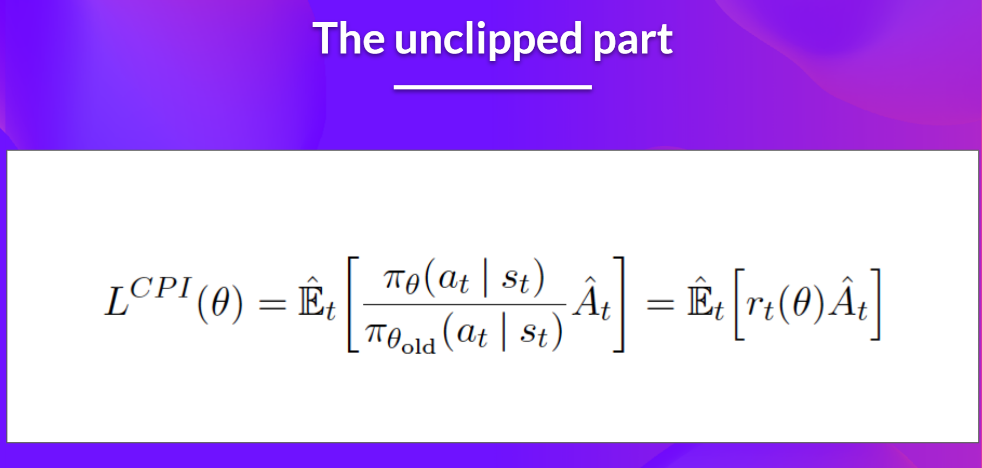



```
pg_losses1 = -advantages * ratio
```


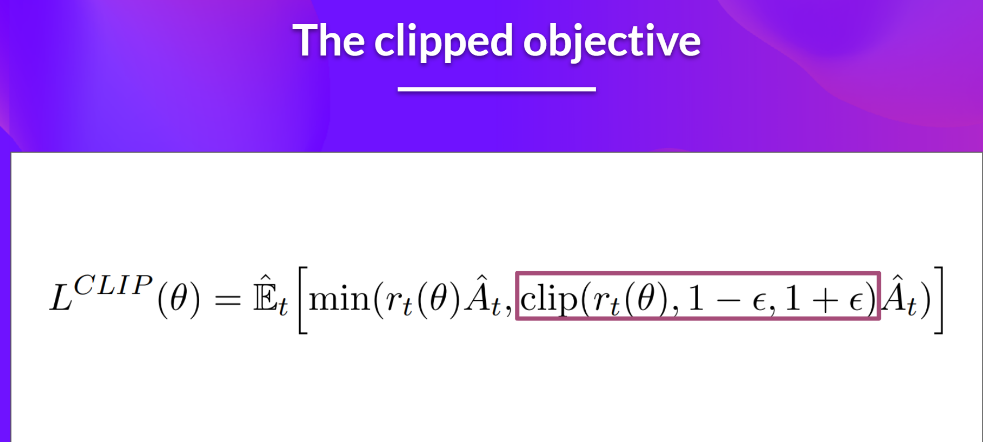


```
    pg_losses2 = -advantages * torch.clamp(ratio, min=1 - self.ppo_clip_range, max=1.0 + self.ppo_clip_range)
```

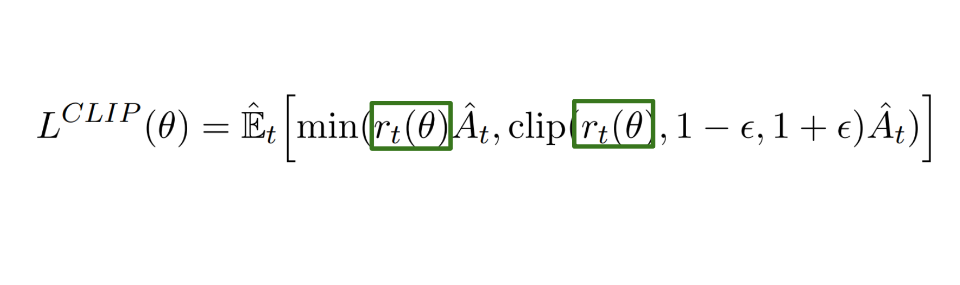



```
    pg_losses1 = -advantages * ratio
    
    pg_losses2 = -advantages * torch.clamp(ratio, min=1 - self.ppo_clip_range, max=1.0 + self.ppo_clip_range)

    pg_loss = reduce_mean(torch.max(pg_losses1, pg_losses2), mask)

```


In [ ]:
# Intitialize policy model

# Intitialize Reference policy model (same as policy model,  but frozen)

# Initialize value model



In [ ]:
# Reward model initialization


In [ ]:
# Train dataloader

#Valuation dataloader, test dataloader (not initialized here, but needs to be)

In [ ]:
# Optimizer


# Scheduler

In [ ]:
# Train loop

In [ ]:
#@title Utility functions
# utility functions


import json
from pathlib import Path
from typing import TypeVar, Iterable, List, Union, Any
import random
import numpy as np
import torch
from tqdm.auto import tqdm
import os
import collections
import re


NEGATIVE_INF  = -100000.0

def reduce_sum(value, mask, axis=None):
    if axis is None:
        return torch.sum(value * mask)
    return torch.sum(value * mask, axis)


def reduce_mean(value, mask, axis=None):
    if axis is None:
        return torch.sum(value * mask) / torch.sum(mask)
    return reduce_sum(value, mask, axis) / torch.sum(mask, axis)


def reduce_std(value, mask):
    return torch.sqrt(reduce_mean(torch.square(value), mask) - torch.square(reduce_mean(value, mask)))


def reduce_var(value, mask):
    return reduce_mean(torch.square(value), mask) - torch.square(reduce_mean(value, mask))


def logits_to_entropy(logits):
    distribution = torch.distributions.Categorical(logits=logits)
    return distribution.entropy()


def mask_pad(value, mask, pad_value=None):
    if pad_value is None:
        pad_value = NEGATIVE_INF
    return value * mask + pad_value * (1 - mask)


def clamp(value, min_value, max_value):
    return torch.max(torch.min(value, max_value), min_value)


def ceil_div(a, b):
    return (a - 1) // b + 1


def exact_div(a, b):
    q = a // b
    if a != q * b:
        raise ValueError('Inexact division: %s / %s = %s' % (a, b, a / b))
    return q


def flatten_dict(nested, sep='.'):
    def rec(nest, prefix, into):
        for k, v in nest.items():
            if sep in k:
                raise ValueError(f"separator '{sep}' not allowed to be in key '{k}'")
            if isinstance(v, collections.Mapping):
                rec(v, prefix + k + sep, into)
            else:
                into[prefix + k] = v
    flat = {}
    rec(nested, '', flat)
    return flat


def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)


def batchify(data, batch_size):
    assert batch_size > 0

    batch = []
    for item in data:
        # Yield next batch
        if len(batch) == batch_size:
            yield batch
            batch = []

        batch.append(item)

    # Yield last un-filled batch
    if len(batch) != 0:
        yield batch


def set_seed(seed=19260817, cuda_deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if torch.cuda.is_available() and cuda_deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def load_jsonl(file: Union[str, Path]) -> Iterable[Any]:
    with open(file) as f:
        for line in f:
            yield json.loads(line)

In [ ]:
#@title Data loader

# Class with functions to read and prepare data
from torch.utils.data import Dataset, DataLoader

class TextGenDataset(Dataset):
  def __init__(self, split, tokenizer,
               accelerator=None, length_limit=None):
    super().__init__()
    self.n_card = 1
    self.tokenizer = tokenizer
    self.split = split
    self.dataset_path = {"train": "PPO data/dev.json", "test": "PPO data/test.json"}  # Update path to location of data file !!!

    self.instances = self.load_datasets()

    if length_limit is not None:
      self.instances = self.instances[:length_limit]

    if split == 'train':
      random.shuffle(self.instances)



    if accelerator is not None:
      self.n_card = accelerator.num_processes

  def __len__(self):
    return len(self.instances)

  def __getitem__(self, idx):
    return self.instances[idx]

  def load_datasets(self):
    instances = []
    task_data = None

    with open(self.dataset_path[self.split], 'r') as f:
      task_data = json.load(f)

    for task_instance in task_data:
      instances.append({
          "prompt": task_instance['text'],
          "metadata": {
              "prompt": task_instance['text'],
              "reference": task_instance['answer'],}
      })

    print(f"Loaded split {self.split} with {len(instances)} total instances")

    instances = instances[:len(instances)//self.n_card*self.n_card]  # or Trainer will stuck
    return instances


  def collate_fn(self, batch):
    #process input prompts
    prompts = [item['prompt'] for item in batch]


    #Batch Encode Plus = Returns a dictionary containing the encoded sequence or sequence pair and additional information: the mask for sequence classification and the overflowing elements if a max_length is specified

    prompts_tok = self.tokenizer.batch_encode_plus(
            prompts,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            #max_length=self.tokenizer.max_input_len,
            )


    prompts_input_ids = prompts_tok.input_ids
    prompts_attention_mask = prompts_tok.attention_mask

    metadata = [item['metadata'] for item in batch]

    result = {
        'prompts_input_ids': prompts_input_ids,
        'prompts_attention_mask': prompts_attention_mask,
        'metadata': metadata
        }
    return result





In [ ]:
#@title Policy model
# Defining the policy model

from typing import Union, List, Dict
import torch
import torch.nn.functional as F
from transformers import T5ForConditionalGeneration
from typing import Optional, List, Iterable, Dict, Any, Tuple

class GPT2Policy:

  def __init__(self, model_ckpt, tokenizer, accelerator):


    self.tokenizer = tokenizer
    self.accelerator = accelerator
    self.model = AutoModelForCausalLM.from_pretrained(model_ckpt)
    self.max_generated_len = 1024

    for param in self.model.parameters():
          param.requires_grad = True

  def sample(self,
             prompts_input_ids, prompts_attention_mask,
             top_k=0.1, top_p=0.9, temperature=0.7, num_beams=1,
             num_return_sequences=1, do_sample=False):

    prompts_text = self.tokenizer.batch_decode(prompts_input_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)



    generated_input_ids = self.model.generate(input_ids = prompts_input_ids,
                                                     attention_mask=prompts_attention_mask,
                                                     max_length=self.max_generated_len + 1,
                                                     do_sample=do_sample,
                                                     #top_k=top_k,
                                                     #top_p=top_p,
                                                     #temperature=temperature,
                                                     num_return_sequences=num_return_sequences,)
                                                     #synced_gpus=True,)


    # BATCH DECODING OF GENERATED TEXT
    generated_input_ids = generated_input_ids[:, 1:].contiguous()

    generated_input_ids = F.pad(generated_input_ids, (0, self.max_generated_len - generated_input_ids.size(1)), value=self.tokenizer.pad_token_id) # (B, output_len)
    generated_attention_mask = (generated_input_ids != self.tokenizer.pad_token_id).long()
    generated_text = self.tokenizer.batch_decode(generated_input_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)


    return {
        'prompts_text': prompts_text,
        'prompts_input_ids': prompts_input_ids,
        'prompts_attention_mask': prompts_attention_mask,
        'generated_text': generated_text,
        'generated_input_ids': generated_input_ids,
        'generated_attention_mask': generated_attention_mask,
    }

  def forward_pass(self, prompts_input_ids, prompts_attention_mask,
                   generated_input_ids, generated_attention_mask):


    outputs = self.model(input_ids=prompts_input_ids,
            attention_mask=prompts_attention_mask,
            labels=mask_pad(generated_input_ids, generated_attention_mask, -100),
            return_dict=True,
            output_attentions=False,
            output_hidden_states=True,)

    generated_logits = outputs.logits
    logprobs = F.log_softmax(generated_logits, dim=-1)
    generated_logprobs = torch.gather(logprobs, 2, generated_input_ids[:, :, None]).squeeze(2) # (B, output_len)
    generated_entropy = logits_to_entropy(generated_logits) # (B, output_len)


    results = {
            'generated_logits': generated_logits, # (B, output_len, V)
            'generated_logprobs': mask_pad(generated_logprobs, generated_attention_mask), # (B, output_len)
            'generated_entropy': mask_pad(generated_entropy, generated_attention_mask), # (B, output_len)
        }

    return results





In [ ]:
#@title Value model
# Define Value model

from typing import Union, List, Dict
import torch
import torch.nn.functional as F
from transformers import T5ForConditionalGeneration
from typing import Optional, List, Iterable, Dict, Any, Tuple



class MLP(torch.nn.Module):

    def __init__(self, d_model, d_out) -> None:
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.GELU(),
            torch.nn.Linear(d_model, d_out),
        )

        for param in self.model.parameters():
          param.requires_grad = True

    def forward(self, x):
        return self.model(x)


class GPT2Value:

  def __init__(self, model_ckpt, tokenizer, accelerator, freeze_model=False):


    self.tokenizer = tokenizer
    self.accelerator = accelerator
    self.model = AutoModelForCausalLM.from_pretrained(model_ckpt)


    self.linear = MLP(768, 1) # hidden dim for GPT2, needs to be updated for different models

    # freeze all parameters except the last layer
    if freeze_model:
      for param in self.model.parameters():
        param.requires_grad = False


  def forward_pass(self, prompts_input_ids, prompts_attention_mask,
                   generated_input_ids, generated_attention_mask):


    outputs = self.model(input_ids=prompts_input_ids,
            attention_mask=prompts_attention_mask,
            labels=mask_pad(generated_input_ids, generated_attention_mask, -100),
            return_dict=True,
            output_attentions=False,
            output_hidden_states=True,)

    # print(outputs.logits.shape)
    # output.hidden_states[-1].shape #torch.Size([1, 10, 768])


    logits = self.linear(outputs.hidden_states[-1]).squeeze(-1) # (B, output_len)


    results = {
                'generated_value': mask_pad(logits, generated_attention_mask, 0), # (B, output_len)
        }

    return results


In [ ]:
#@title Base Reward class
# Reward model
import abc
import numpy as np
import torch
from typing import Optional, List, Iterable, Dict, Any, Tuple

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    HfArgumentParser,
    RobertaForSequenceClassification,
    RobertaTokenizer,
)



class BasicReward(metaclass=abc.ABCMeta):

    def __init__(self,
                 kl_coef,
                ):
        self.kl_coef = kl_coef

        toxicity_model_id = "facebook/roberta-hate-speech-dynabench-r4-target"

        self.reward_tokenizer = RobertaTokenizer.from_pretrained(toxicity_model_id) #AutoTokenizer.from_pretrained(model_ckpt)
        self.model =  RobertaForSequenceClassification.from_pretrained(toxicity_model_id, torch_dtype=torch.float16) #AutoModelForSequenceClassification.from_pretrained(model_ckpt)
        self.softmax = torch.nn.Softmax(dim=1)

        self.generation_kwargs = {
                                "min_length": -1,
                                "top_k": 0.0,
                                "top_p": 1.0,
                                "do_sample": True,
                                "pad_token_id": tokenizer.eos_token_id,
                            }

    @abc.abstractmethod
    def get_reward(self,
                   prompts_input_ids: torch.tensor, # (B, input_len)
                   prompts_attention_mask: torch.tensor, # (B, input_len)
                   generated_input_ids: torch.tensor, # (B, output_len)
                   generated_attention_mask: torch.tensor, # (B, output_len)
                   generated_texts: List[str], # [B]
                   metadata = None,
                  ) -> Dict[str, List[List[float]]]:
          pass


    def kl_penalize_reward(self, results):
        logprobs = results['generated_logprobs']
        ref_logprobs = results['generated_ref_logprobs']
        mask = results['generated_attention_mask']

        # should be a list of length B to avoid gradient descent
        raw_rewards = results['rewards/raw']
        kl = mask_pad(logprobs - ref_logprobs, mask, pad_value=0.)
        kl_penalty = self.kl_coef * kl
        RL = logprobs.size(1)

        flattened_rewards = torch.tensor([
            r + [0.] * (RL-len(r))
            for r in raw_rewards
        ], device=logprobs.device)

        penalized_rewards = flattened_rewards - kl_penalty

        results['rewards/raw'] = flattened_rewards
        results['rewards/kl'] = kl
        results['rewards/kl_penalty'] = kl_penalty
        results['rewards/penalized'] = penalized_rewards








In [ ]:
#@title Reward classifier
class PreferenceReward:
    def __init__(self,
                 tokenizer,
                 model_ckpt,
                 mean = 0.0,
                 std = 1.0,
                 bias = 0.0,
                 scale = 1.0,
                 ):

        # use mean and std to normalize the reward
        # use bias and scale to rescale the reward
        # Not used in this tutorial
        # prepare policy tokenizer
        self.policy_tokenizer = tokenizer
        toxicity_model_id = "facebook/roberta-hate-speech-dynabench-r4-target"


        self.reward_tokenizer = RobertaTokenizer.from_pretrained(toxicity_model_id) #AutoTokenizer.from_pretrained(model_ckpt)
        self.model =  RobertaForSequenceClassification.from_pretrained(toxicity_model_id, torch_dtype=torch.float32) #AutoModelForSequenceClassification.from_pretrained(model_ckpt)

        for param in self.model.parameters():
            param.requires_grad = False
        self.model.eval()

        self.mean = mean
        self.std = std

        self.bias = bias
        self.scale = scale

    def get_reward(self,
                   prompts_input_ids: torch.tensor,
                   prompts_attention_mask: torch.tensor,
                   generated_input_ids: torch.tensor, # (B, output_len)
                   generated_attention_mask: torch.tensor, # (B, output_len)
                   generated_texts: List[str],
                   metadata=None,
                   ):
        batch_reward_inputs = []

        for batch_idx, (meta, gen_text) in enumerate(zip(metadata, generated_texts)):
            reward_input = f"{' '.join(meta['prompt'].split())} answer: {gen_text}"
            batch_reward_inputs.append(reward_input)

        # get the reward
        with torch.no_grad():
            # to align with the token classification model
            inputs =self.reward_tokenizer(batch_reward_inputs,
                                          truncation=True, padding=True,
                                          return_tensors="pt")
            inputs = inputs.to(self.model.device)
            outputs = self.model(**inputs)
            sequence_level_reward = outputs['logits'][:,0].squeeze(-1).tolist()


        # align with generated texts, make it fine-grained
        fine_grained_reward = [
            [0.] * (l-1) + [((r-self.mean)/self.std)*self.scale + self.bias]
            for r, l in zip(sequence_level_reward, torch.sum(generated_attention_mask, dim=1).tolist())
        ]

        return fine_grained_reward


In [ ]:
#@title Reward Class
import spacy

class BaselineReward(BasicReward):

    def __init__(self,
                 tokenizer,
                 baseline_model_ckpt,
                 kl_coef,
                 baseline_reward_mean = 0.0,
                 baseline_reward_std = 1.0,
                 baseline_reward_bias = 0.0,
                 baseline_reward_scale = 1.0,
                ):

        super().__init__(kl_coef)

        self.baseline_reward = PreferenceReward(tokenizer,
            baseline_model_ckpt,
            mean=baseline_reward_mean,
            std=baseline_reward_std,
            bias=baseline_reward_bias,
            scale=baseline_reward_scale)

        self.nlp = spacy.load("en_core_web_sm")


    def get_reward(self,
                   prompts_input_ids: torch.tensor,
                   prompts_attention_mask: torch.tensor,
                   generated_input_ids: torch.tensor, # (B, output_len)
                   generated_attention_mask: torch.tensor, # (B, output_len)
                   generated_texts: List[str],
                   metadata=None,
                   override_gain=None,
                   override_bias=None):

        rewards = self.baseline_reward.get_reward(prompts_input_ids, prompts_attention_mask,
                                                generated_input_ids, generated_attention_mask,
                                                generated_texts, metadata)

        return {'rewards/raw': rewards}


    def eval_metrics(self,
                prompts_input_ids: torch.tensor,
                prompts_attention_mask: torch.tensor,
                generated_input_ids: torch.tensor, # (B, output_len)
                generated_attention_mask: torch.tensor, # (B, output_len)
                generated_texts: List[str],
                metadata=None,
                override_gain=None,
                override_bias=None):

        output = {}
        baseline_rewards_output = self.get_reward(prompts_input_ids, prompts_attention_mask,
                                                generated_input_ids, generated_attention_mask,
                                                generated_texts, metadata)['rewards/raw']

        # lens of generations
        generation_lens = torch.sum(generated_attention_mask, dim=-1).tolist()

        output.update({
            "eval/rewards": [np.sum(sublist) for sublist in baseline_rewards_output],
            "eval/lengths": generation_lens
        })

        return output

In [ ]:
#@title Trainer - PPO
class PPOTrainer:
  def __init__(self, train_dataloader,
               eval_dataloader,
               ref_policy_model,
               policy_model,
               value_model,
               reward_model,
               optimizer,
               scheduler,
               accelerator,
               ):
    self.accelerator = accelerator #!!!!
    self.train_dataloader = train_dataloader
    self.eval_dataloader = eval_dataloader
    self.ref_policy_model = ref_policy_model
    self.policy_model = policy_model
    self.value_model = value_model
    self.reward_model = reward_model
    self.optimizer = optimizer
    self.scheduler = scheduler

    self.gamma = 0.9 # GAMMA !
    self.ppo_lam = 0.1 #!
    self.ppo_clip_range = 0.1 #!
    self.ppo_pg_coef = 0.1 #!
    self.ppo_vf_coef = 0.1 #!
    self.train_num_samples_per_input = 1
    self.n_ppo_epoch_per_rollout = 1 #4
    self.training_batch_size_per_card = 1 #!


    self.should_early_stop = False
    self.huge_kl_count = 0

    self.batchify = lambda x, n: [x[i:i + n] for i in range(0, len(x), n)]

    self.train_sampler = iter(self.train_dataloader)
    for _ in range(len(self.train_dataloader)):
      next(self.train_sampler)

    self.eval_accs = {}


  def compute_advantages(self, results, num_samples):
    #the extra reward we get if we take this action at that state
    #compared to the mean reward we get at that state.

    old_values = results['generated_value']

    rewards = results['rewards/penalized']
    mask = results['generated_attention_mask'] #(B, KL)

    with torch.no_grad():
      lastgaelam = 0
      whitened_rewards = rewards
      advantages_reversed = []
      gen_length = mask.sum(dim=1).max().item()

      for t in reversed(range(gen_length)):
        nextvalues = old_values[:, t+1] if t< gen_length -1 else 0.0  # so if old_values = [2,6,1,3,6,7], next_value for t=4 is 7
        delta = whitened_rewards[:, t] + self.gamma * nextvalues - old_values[:, t]
        lastgaelam = delta + self.gamma * self.ppo_lam * lastgaelam
        advantages_reversed.append(lastgaelam)



      advantages = torch.stack(advantages_reversed[::-1], dim=1)

      advantages = F.pad(advantages, (0, rewards.size(1) - gen_length), value=0.0)

      returns = advantages + old_values

    results['advantages'] = advantages
    results['returns'] = returns



  def loss(self, results, all_mask_weight):

    old_values = results['generated_value']
    old_logprobs = results['generated_logprobs']
    mask = results['generated_attention_mask'] # (B, KL)

    advantages = results['advantages']
    returns = results['returns']

    weight = mask.sum(dim=1).float().mean().item() / all_mask_weight



    forward_inputs = {
        'prompts_input_ids' : results['prompts_input_ids'],
        'prompts_attention_mask': results['prompts_attention_mask'],
        'generated_input_ids': results['generated_input_ids'],
        'generated_attention_mask' : results['generated_attention_mask'],
    }

# Run inputs through POLICY model
    policy_forward = self.policy_model.forward_pass(**forward_inputs)
    new_logprobs = policy_forward['generated_logprobs']

    ratio = torch.exp(new_logprobs- old_logprobs)
    pg_losses1 = -advantages * ratio
    pg_losses2 = -advantages * torch.clamp(ratio, min=1.0 - self.ppo_clip_range, max=1.0 + self.ppo_clip_range)
    pg_loss = reduce_mean(torch.max(pg_losses1, pg_losses2), mask)
    pg_loss = pg_loss * weight


# Run inputs through VALUE model
    value_forward = self.value_model.forward_pass(**forward_inputs)
    new_values = value_forward['generated_value']
    new_values *= mask

    new_values_clipped = clamp(new_values, old_values - self.ppo_clip_range, old_values + self.ppo_clip_range)
    vf_losses1 = torch.square(new_values - returns)
    vf_losses2 = torch.square(new_values_clipped - returns)

    vf_loss = 0.5 * reduce_mean(torch.max(vf_losses1, vf_losses2), mask)
    vf_loss = vf_loss * weight


    loss = self.ppo_pg_coef * pg_loss + self.ppo_vf_coef * vf_loss

    results['loss/total'] = loss
    results['loss/policy'] = pg_loss
    results['loss/value'] = vf_loss


  def train(self, step):
    self.accelerator.wait_for_everyone()
    try:
      batch = next(self.train_sampler)

    except StopIteration:
      self.train_sampler = iter(self.train_dataloader)
      batch = next(self.train_sampler)

    self.ref_policy_model.model.eval()
    self.policy_model.model.eval()
    self.value_model.model.eval()
    self.value_model.linear.eval()


    # Rollout from current policy
    with torch.no_grad():
      results = self.policy_model.sample(
          prompts_input_ids = batch['prompts_input_ids'],
          prompts_attention_mask = batch['prompts_attention_mask'],
          num_return_sequences = self.train_num_samples_per_input,

      )

    forward_inputs = {
          'prompts_input_ids': results['prompts_input_ids'],
          'prompts_attention_mask': results['prompts_attention_mask'],
          'generated_input_ids': results['generated_input_ids'],
          'generated_attention_mask': results['generated_attention_mask'],

      }

      # One forward pass with policy model
    with torch.no_grad():
        policy_forward = self.policy_model.forward_pass(**forward_inputs)
        results.update(policy_forward)

      # Get associated value from VALUE model
    with torch.no_grad():
        value_forward = self.value_model.forward_pass(**forward_inputs)
        results['generated_value'] = value_forward['generated_value']
        results['generated_value'] *= results['generated_attention_mask']

      # Run reference policy
    with torch.no_grad():
        ref_policy_forward = self.ref_policy_model.forward_pass(**forward_inputs)
        results['generated_ref_logits'] = ref_policy_forward['generated_logits']
        results['generated_ref_logprobs'] = ref_policy_forward['generated_logprobs']

      # Get reward for the policy model generation
    with torch.no_grad():
        reward_results = self.reward_model.get_reward(
            prompts_input_ids=results['prompts_input_ids'],
            prompts_attention_mask=results['prompts_attention_mask'],
            generated_input_ids=results['generated_input_ids'],
            generated_attention_mask=results['generated_attention_mask'],
            generated_texts=results['generated_text'],
            metadata = [elem for elem in batch['metadata'] for _ in range(self.train_num_samples_per_input)],
        )
        results.update(reward_results)
        self.reward_model.kl_penalize_reward(results) #!!!

      # Get the advantages
    self.compute_advantages(results, self.train_num_samples_per_input)
    n_results = len(results['generated_input_ids'])

    loss_totals, loss_policies, loss_values =  [], [], []
    reward_penalizeds, reward_kls, reward_raws = [], [], []

      # Train
      # Do multiple epochs of PPO training, with a fresh random shuffle in each epoch


    self.policy_model.model.train()
    self.value_model.model.train()
    self.value_model.linear.train()


    for ppo_epoch_idx in range(self.n_ppo_epoch_per_rollout):

      self.optimizer.zero_grad()
      mask = results['generated_attention_mask']
      all_mask = self.accelerator.gather(mask) #!!!
      all_mask_weight = all_mask.sum(dim=1).float().mean().item()

      for batch_idx in range(0,n_results, self.training_batch_size_per_card):
          batch_results = {}
          for k,v in results.items():
              batch_results[k] = v[batch_idx: batch_idx+self.training_batch_size_per_card]

          self.loss(batch_results, all_mask_weight)

          self.accelerator.backward(batch_results['loss/total'])
          # logging ----------------------------------------------------------------------------------------------------------------------------------------------
          if ppo_epoch_idx == self.n_ppo_epoch_per_rollout - 1:
            loss_total = batch_results['loss/total'].unsqueeze(0) # (1)
            loss_policy = batch_results['loss/policy'].unsqueeze(0) # (1)
            loss_value = batch_results['loss/value'].unsqueeze(0) # (1)
            reward_penalized = torch.mean(reduce_sum(batch_results['rewards/penalized'], batch_results['generated_attention_mask'], axis=1)).unsqueeze(0) # (1)
            reward_kl = torch.mean(reduce_sum(batch_results['rewards/kl'], batch_results['generated_attention_mask'], axis=1)).unsqueeze(0) # (1)
            reward_raw =  torch.mean(reduce_sum(batch_results['rewards/raw'], batch_results['generated_attention_mask'], axis=1)).unsqueeze(0) # (1)

            loss_totals.append(loss_total)
            loss_policies.append(loss_policy)
            loss_values.append(loss_value)
            reward_penalizeds.append(reward_penalized)
            reward_kls.append(reward_kl)
            reward_raws.append(reward_raw)

      self.optimizer.step()
      self.scheduler.step()



    loss_total = torch.cat(loss_totals, dim=0)
    loss_policy = torch.cat(loss_policies, dim=0)
    loss_value = torch.cat(loss_values, dim=0)
    reward_penalized = torch.cat(reward_penalizeds, dim=0)
    reward_kl = torch.cat(reward_kls, dim=0)
    reward_raw = torch.cat(reward_raws, dim=0)



    losses_total = self.accelerator.gather(loss_total) # (num_gpus)
    losses_policy = self.accelerator.gather(loss_policy) # (num_gpus)

    losses_value = self.accelerator.gather(loss_value) # (num_gpus)
    rewards_penalized = self.accelerator.gather(reward_penalized) # (num_gpus)
    rewards_kl = self.accelerator.gather(reward_kl) # (num_gpus)
    rewards_raw = self.accelerator.gather(reward_raw) # (num_gpus)


    loss_total = losses_total.mean().item()
    loss_policy = losses_policy.mean().item()

    loss_value = losses_value.mean().item()
    reward_penalized = rewards_penalized.mean().item()
    reward_kl = rewards_kl.mean().item()
    reward_raw = rewards_raw.mean().item()

    print("Reward: ", reward_raw)
    print("Loss: ", loss_total)





In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
# You can pass different model checkpoint, and update the parameters in code accordingly

model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token

In [ ]:
import accelerate
# prepare accelerator and logger
accelerator = accelerate.Accelerator()

In [ ]:
train_dataset = TextGenDataset("train", tokenizer, accelerator=accelerator, length_limit=5)
# train ds is shuffled in its constructor

batch_size = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=False, drop_last=True, collate_fn=train_dataset.collate_fn)

eval_dataset = TextGenDataset('test',  tokenizer, accelerator=accelerator, length_limit=1)

eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size,
                                 shuffle=False, drop_last=False, collate_fn=eval_dataset.collate_fn)

train_dataloader, eval_dataloader = accelerator.prepare(train_dataloader, eval_dataloader)



Loaded split train with 948 total instances
Loaded split test with 948 total instances


In [ ]:
policy = GPT2Policy("gpt2", tokenizer, accelerator)

In [ ]:
ref_policy =  GPT2Policy("gpt2", tokenizer, accelerator)

In [ ]:
value = GPT2Value("gpt2", tokenizer, accelerator)

In [ ]:
reward = BaselineReward(tokenizer, 'model_ckpt',0.5)

In [ ]:
policy.model = accelerator.prepare(policy.model)

In [ ]:
from itertools import chain
import transformers

parameters = chain(policy.model.parameters(), value.model.parameters())

lr = 0.01


optimizer = torch.optim.Adam(parameters, lr=lr, eps=1e-5)

total_episodes = 10
batch_size = 2
train_num_samples_per_input = 1

total_steps = ceil_div(total_episodes,
                                batch_size * accelerator.num_processes * train_num_samples_per_input)


n_ppo_epoch_per_rollout = 1

scheduler = transformers.get_scheduler(
        name='linear',
        optimizer=optimizer,
        num_warmup_steps=100*n_ppo_epoch_per_rollout*accelerator.num_processes,
        num_training_steps=total_steps*n_ppo_epoch_per_rollout*accelerator.num_processes,
    )

optimizer, scheduler = accelerator.prepare(optimizer, scheduler)

In [ ]:
trainer = PPOTrainer(
        train_dataloader=train_dataloader,
        eval_dataloader=eval_dataloader,
        ref_policy_model=ref_policy,
        policy_model=policy,
        value_model=value,
        reward_model=reward,
        optimizer=optimizer,
        scheduler=scheduler,
        accelerator=accelerator,
    )

In [ ]:
total_steps = 5

steps = list(range(total_steps+1))
steps = tqdm(steps) if accelerator.is_main_process else steps

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
for step in steps:
  if(step ==1):
    break # terminating early for demo purpose
  trainer.train(step)
  accelerator.wait_for_everyone()



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
 17%|█▋        | 1/6 [03:26<17:10, 206.02s/it]

Reward:  0.0
Loss:  0.1377628743648529


 17%|█▋        | 1/6 [03:26<17:10, 206.20s/it]


# For debugging

In [ ]:
# # x = [2,6,1,3,6,7]
# # print("Len of x: ",len(x))
# # for t in reversed(range(len(x))):
# #   next_value = x[t+1] if t<len(x)-1 else 0
# #   print(f"Index: {t}, Next value for {x[t]} is {next_value}")


# Len of x:  6
# Index: 5, Next value for 7 is 0
# Index: 4, Next value for 6 is 7
# Index: 3, Next value for 3 is 6
# Index: 2, Next value for 1 is 3
# Index: 1, Next value for 6 is 1
# Index: 0, Next value for 2 is 6

# x = [1,2,3,4,5,6,7,8,9,0]
# n = 2

# batchify = lambda x, n: [x[i:i + n] for i in range(0, len(x), n)]
# batchify(x,n)


# [[1, 2], [3, 4], [5, 6], [7, 8], [9, 0]]


# train_dataloader = [{'query':'prompt','response':'answer'},{'query':'prompt0','response':'answer0'},{'query':'prompt1','response':'answer1'},{'query':'prompt2','response':'answer2'}]
# train_sampler = iter(train_dataloader)

# #when you need more control over the iteration process, such as pausing and resuming the iteration,
# # or when working with large datasets where you want to manage memory usage more efficiently

# for _ in range(len(train_dataloader)):
#   print(next(train_sampler))



# {'query': 'prompt', 'response': 'answer'}
# {'query': 'prompt0', 'response': 'answer0'}
# {'query': 'prompt1', 'response': 'answer1'}
# {'query': 'prompt2', 'response': 'answer2'}